# 2. Correlación entre contaminantes

Usando el archivo generado en el notebook `01_concatenar_archivos.ipynb` se estructura primero el dataframe para correr la función de correlación en python y graficar la matriz correspondiente.

Después se construye una función que servirá para obtener la correlación con un desfase determinado de tiempo.

Dado que son necesarias las correlaciones del O3 y PM10 con los demás contaminantes, se crean nuevos dataframes que se guardarán en archivos csv correspondientes (para usarse en los modelos de predicción) y se graficaran las correlaciones correspondientes.

Se importan las bibliotecas necesarias.

In [1]:
1+1

2

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix

Se carga el archivo generado anteriormente.

In [23]:
!pwd

/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/contaminación/correlaciones_pau


In [24]:
data = pd.read_csv(str("/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/contaminación/pipeline_norberto_11horas/datos/datos_entrenamiento.csv"))

In [25]:
data.head()

,RH,TMP,WSP,id_station,fecha,CO,NO,NO2,NOX,O3,PM10,PM2.5,SO2,hora,dia,mes,PM10mean,PM25mean
0,82.0,9.0,1.8,ACO,2015-01-01 01:00:00,0.6,14.0,21.0,35.0,4.0,84.0,NaN,4.0,1,1.0,1.0,NaN,NaN
1,NaN,NaN,1.3,AJM,2015-01-01 01:00:00,1.2,3.0,58.0,61.0,8.0,NaN,NaN,20.0,1,1.0,1.0,NaN,NaN
2,NaN,NaN,NaN,AJU,2015-01-01 01:00:00,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,1,1.0,1.0,NaN,NaN
3,NaN,NaN,NaN,ATI,2015-01-01 01:00:00,1.1,3.0,30.0,32.0,21.0,122.0,NaN,16.0,1,1.0,1.0,NaN,NaN
4,NaN,NaN,NaN,CAM,2015-01-01 01:00:00,1.2,NaN,NaN,NaN,2.0,95.0,80.0,67.0,1,1.0,1.0,NaN,NaN


Como se puede observar, se necesita reestructurar el dataframe para que se pueda correr la correlación. Es necesario quitar algunas columnas y reiniciar índices.

## 2.1 Estructuración del dataframe

Se eliminan las columnas `Unnamed:0`, `mes`, `dia` y `hora`, pues no son de nuestra utilidad. También se ordenan los datos por la columna `fecha` de manera ascendente, lo cual es fundamental para que posteriormente se construya la correlación con el desfase de tiempo 

In [26]:
#data.drop(['index'], axis = 1, inplace = True)
data = data.sort_values(by = 'fecha')
data = data.reset_index(drop = True)

In [27]:
data = data.groupby('fecha', as_index = False).max()

In [28]:
data.head()

,fecha,RH,TMP,WSP,id_station,CO,NO,NO2,NOX,O3,PM10,PM2.5,SO2,hora,dia,mes,PM10mean,PM25mean
0,2015-01-01 01:00:00,95.0,13.2,2.7,XAL,2.9,113.0,62.0,150.0,26.0,211.0,159.0,86.0,1,1.0,1.0,NaN,NaN
1,2015-01-01 02:00:00,96.0,12.4,2.8,XAL,3.4,149.0,58.0,183.0,31.0,293.0,267.0,87.0,2,1.0,1.0,NaN,NaN
2,2015-01-01 03:00:00,97.0,11.8,2.5,XAL,2.8,115.0,52.0,144.0,26.0,266.0,242.0,133.0,3,1.0,1.0,NaN,NaN
3,2015-01-01 04:00:00,97.0,11.7,2.7,XAL,2.4,105.0,46.0,131.0,28.0,225.0,161.0,152.0,4,1.0,1.0,NaN,NaN
4,2015-01-01 05:00:00,98.0,10.1,2.2,XAL,2.2,75.0,44.0,99.0,21.0,278.0,141.0,88.0,5,1.0,1.0,NaN,NaN


## 2.2 Correlación entre contaminantes

Usando los datos anteriores ya podemos obtener la correlación y la matriz de correlación entre los contaminantes.

Se construye un filtro para que a demanda el usuario obtenga la correlación del contaminante deseado.

## 2.3 Correlación cruzada entre contaminantes

Es necesario conocer la correlación entre los contaminantes a distintos rangos de tiempo. Por ejemplo, es de interés saber si las partículas PM10 aumentan o disminuyen 24 hrs después de que subió el O3 o algún otro contaminante. Para ello se construye una función que calcule la correlación desfasada cada hora.

Esta función fue obtenida en un artículo de kaggle titulado [Cross-correlation (time-lag) with pandas](https://www.kaggle.com/dedecu/cross-correlation-time-lag-with-pandas) y aplicada en este trabajo: 

In [29]:
def data_lag(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df

El desfase se hará para 72 horas aplicando la función anterior a los datos que se tienen.

In [30]:
NON_DER = ['fecha',]
data_72 = data_lag(data, 72, NON_DER)

Se corre la correlación para este desfase y se guarda en un nuevo dataframe.

In [31]:
data_72_corr = data_72.corr()

La tabla obtenida tiene todos los valores desfasados hasta 72 horas. Por ejemplo la columna indicada como PM10_63 muestra la correlación de todos los contaminantes con diferencia de 63 horas para el PM10.

In [32]:
data_72_corr.head()

,RH,TMP,WSP,CO,NO,NO2,NOX,O3,PM10,PM2.5,...,PM25mean_63,PM25mean_64,PM25mean_65,PM25mean_66,PM25mean_67,PM25mean_68,PM25mean_69,PM25mean_70,PM25mean_71,PM25mean_72
RH,1.000000,-0.698605,-0.311534,0.208510,0.311446,0.025646,0.270536,-0.696646,-0.196106,-0.149567,...,-0.113602,-0.114144,-0.114615,-0.114806,-0.114874,-0.114853,-0.114751,-0.114538,-0.114396,-0.114275
TMP,-0.698605,1.000000,0.395652,-0.390877,-0.532917,-0.211573,-0.511549,0.781149,-0.036303,-0.003274,...,-0.050060,-0.050506,-0.050986,-0.051408,-0.051819,-0.052279,-0.052651,-0.052899,-0.053110,-0.053356
WSP,-0.311534,0.395652,1.000000,-0.334312,-0.337803,-0.299799,-0.364994,0.274105,-0.027934,-0.218540,...,0.007055,0.007565,0.008174,0.008717,0.009088,0.009497,0.010099,0.010782,0.011280,0.011618
CO,0.208510,-0.390877,-0.334312,1.000000,0.837227,0.609191,0.886642,-0.242849,0.571666,0.436669,...,0.157025,0.157292,0.157198,0.157312,0.157252,0.157213,0.157417,0.157845,0.158380,0.158626
NO,0.311446,-0.532917,-0.337803,0.837227,1.000000,0.380191,0.973181,-0.373484,0.473268,0.292599,...,0.101475,0.101763,0.101796,0.101927,0.101814,0.101830,0.102100,0.102599,0.102921,0.103172


### 2.3.1 Correlación entre PM10 y los demás contaminantes

Siendo las partículas PM10 uno de los determinantes para detonar una contingencia ambiental, interesa saber de que manera se correlacionan con los demás contaminantes y en que ciclos de tiempo dicha correlación es más fuerte.

Se graficará esta correlación para el rango de 0 a 72 horas obtenido en la sección anterior.

Antes de correr la correlación se le vuelve a dar estructura al dataframe para poder graficar de manera óptima.

In [42]:
# Se aísla sólo la columna que corresponde a las partículas PM10
PM10_72 = data_72_corr[["O3"]]

In [43]:
# Se reinicia el índice del dataframe
PM10_72.reset_index(inplace=True)

In [44]:
# Se renombran las columnas para mayor comprensión
PM10_72.columns = ['contaminante', 'valor']

El dataframe tendrá la siguiente estructura:

In [45]:
PM10_72.head()

,contaminante,valor
0,RH,-0.696646
1,TMP,0.781149
2,WSP,0.274105
3,CO,-0.242849
4,NO,-0.373484


In [46]:
PM10_72.columns = ['contaminante', 'valor']

In [47]:
PM10_72['horas'] = PM10_72['contaminante'].str.split('_').str[-1]
PM10_72['contaminante'] = PM10_72['contaminante'].str.split('_').str[0]
PM10_72.fillna(0,inplace=True)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/paw/software/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/paw/software/python/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http:/

In [48]:
PM10_72.reset_index(inplace=True,drop=True)

PM10_72.horas = pd.to_numeric(PM10_72.horas, errors='coerce').fillna(0)

PM10_72.head(10)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,contaminante,valor,horas
0,RH,-0.696646,0.0
1,TMP,0.781149,0.0
2,WSP,0.274105,0.0
3,CO,-0.242849,0.0
4,NO,-0.373484,0.0
5,NO2,-0.052427,0.0
6,NOX,-0.335120,0.0
7,O3,1.000000,0.0
8,PM10,0.136825,0.0
9,PM2.5,0.219638,0.0


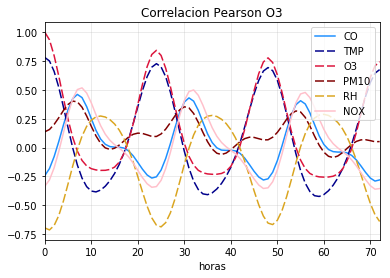

In [49]:
pv = pd.pivot_table(PM10_72, values='valor', index=['horas'],columns=['contaminante'], aggfunc=np.sum)

pv = pv.reset_index(drop=False)

pv.horas = pv.horas.astype(int)
pv = pv.sort_values(by='horas', ascending=True)

pv.head()

fig = plt.figure()
ax = fig.gca()

pv.plot(x="horas", y=["CO"],ax=ax,color="dodgerblue")
pv.plot(x="horas", y=["TMP"],ax=ax,color='darkblue',dashes=[6, 2])
pv.plot(x="horas", y=["O3"],ax=ax,color='crimson',dashes=[6, 2])
pv.plot(x="horas", y=["PM10"],ax=ax,color='maroon',dashes=[6, 2])
pv.plot(x="horas", y=["RH"],ax=ax,color='goldenrod',dashes=[6, 2])
pv.plot(x="horas", y=["NOX"],ax=ax,color='pink')



plt.title("Correlacion Pearson O3")


# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.01)
ax.grid(which='major', alpha=0.3)

#plt.savefig('/home/paw/DanielBustillos/contaminación/imagenes/o3_comparacion.png', bbox_inches='tight'
 #           , dpi=400)
plt.legend()
plt.show()

El índice de este dataframe indica las horas,la columna contaminante junto con la columna valor da la correlación entre el PM10 y el contaminante indicado a la hora indicada. Por ejemplo la fila con índice `29` contaminante `UVA_14` y valor `-0.265479`, nos dice que la correlación del PM10 con los rayos UVA después de 14 horas es de `-0.265479`.

La estructura de este dataframe es poco práctica para poder graficar y obtener un archivo csv con las correlaciones. Por ello se parte primero este dataframe en dos y se trabajará cada uno de manera distinta.

El objetivo es tener un dataframe con columnas `horas`, `UVA`, `UVB`,..., `PM10` y que cada celda represente la correlación a la hora indicada.

Primero separamos las primeras 16 filas de este dataframe en otro más pequeño. El resultante serán los valores de la correlación a la hora 0.

### Export

In [50]:
PM10_72.to_csv("./O3_max_corr.csv", sep=',', encoding='utf-8',index=False)